In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json, sys, platform

# ---- Project root & folders ----
ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
DATA = ROOT / "data"
DATA.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("Project root:", ROOT)
print("Data dir:", DATA)

# ---- Define a minimal, consistent schema for beam records (edit later as needed) ----
schema = [
    # Geometry (mm)
    ("b_mm",        "int32",  "beam width"),
    ("h_mm",        "int32",  "beam total depth"),
    ("cover_mm",    "int32",  "concrete cover (tension side)"),
    ("span_mm",     "int32",  "clear span"),

    # Materials
    ("f_ck_MPa",    "int32",  "concrete compressive strength (cube/cyl as defined in your codebase)"),
    ("f_y_MPa",     "int32",  "steel yield strength"),

    # Reinforcement (tension side total area, mm^2) — can expand per bar sizes later
    ("As_tens_mm2", "float64","tension steel area"),
    ("As_comp_mm2", "float64","compression steel area (0 if none)"),

    # Loads (kN/m or kN as you decide — keep units consistent)
    ("g_k_kNm",     "float64","permanent action resultant (moment or line load; pick one convention)"),
    ("q_k_kNm",     "float64","variable action resultant"),

    # Derived capacities/limits (targets for ANN)
    ("Mu_Rd_kNm",   "float64","bending resistance"),
    ("Vu_Rd_kN",    "float64","shear resistance"),

    # Serviceability checks (ratio = demand/limit, < 1.0 is pass)
    ("defl_ratio",  "float64","deflection ratio (long-term or total)"),
    ("crack_ratio", "float64","crack width ratio"),

    # Label / validity
    ("is_valid",    "int8",   "1 if passes all design checks, else 0"),
]

# ---- Create an empty DataFrame with types ----
df_empty = pd.DataFrame({name: pd.Series(dtype=dtype) for name, dtype, _ in schema})

# ---- Save schema CSV + a JSON schema for reference ----
schema_csv = DATA / "beam_schema_empty.csv"
schema_json = DATA / "beam_schema.json"
df_empty.to_csv(schema_csv, index=False)
with open(schema_json, "w", encoding="utf-8") as f:
    json.dump([{"name":n,"dtype":t,"desc":d} for n,t,d in schema], f, indent=2)

print("Wrote:", schema_csv.name, "and", schema_json.name)
display(df_empty.dtypes)


Python: 3.10.18 | OS: Windows-10-10.0.19045-SP0
Project root: C:\Users\amirn\thesis-rc-beam
Data dir: C:\Users\amirn\thesis-rc-beam\data
Wrote: beam_schema_empty.csv and beam_schema.json


b_mm             int32
h_mm             int32
cover_mm         int32
span_mm          int32
f_ck_MPa         int32
f_y_MPa          int32
As_tens_mm2    float64
As_comp_mm2    float64
g_k_kNm        float64
q_k_kNm        float64
Mu_Rd_kNm      float64
Vu_Rd_kN       float64
defl_ratio     float64
crack_ratio    float64
is_valid          int8
dtype: object

In [2]:
# Step 16 — Synthetic sample dataset for plumbing/tests (NOT a code-compliant design calculator)

from pathlib import Path
import numpy as np, pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
DATA = ROOT / "data"
DATA.mkdir(exist_ok=True, parents=True)

rng = np.random.default_rng(42)
N = 200  # small sample for testing

# Discrete, practical choices
b_choices   = np.array([300,350,400,450,500,550,600])    # mm
h_choices   = np.array([500,550,650,700,750])            # mm
span_choices= np.arange(6000, 9001, 500)                 # mm
fck_choices = np.array([30,35,40])                       # MPa (simplified)
fy_choices  = np.array([500,550])                        # MPa
cover_choices = np.array([30,35,40])                     # mm

# Bar areas (mm^2): 12,14,16,20,25
bar_phi = np.array([12,14,16,20,25])
bar_area = np.pi*(bar_phi**2)/4.0

def sample_As(count_rng=(4,9), phi_rng=(0,len(bar_phi))):
    n = rng.integers(*count_rng)               # 4..8 bars
    idx = rng.integers(*phi_rng, size=n)       # random diameters
    return float(bar_area[idx].sum())

rows = []
for _ in range(N):
    b = int(rng.choice(b_choices))
    h = int(rng.choice(h_choices))
    cover = int(rng.choice(cover_choices))
    span = int(rng.choice(span_choices))
    f_ck = int(rng.choice(fck_choices))
    f_y  = int(rng.choice(fy_choices))

    # Reinforcement (very rough for testing)
    As_t = sample_As()
    As_c = float(As_t*rng.choice([0.0, 0.15, 0.25]))  # sometimes compression steel

    # Loads: choose characteristic line loads (kN/m)
    gk = float(rng.uniform(8, 16))   # permanent
    qk = float(rng.uniform(3, 8))    # variable

    # ULS design: crude combination and midspan moment for simply-supported beam
    Lm = span/1000.0
    wuls = 1.35*gk + 1.5*qk                  # kN/m
    Mu_Ed = wuls*Lm**2/8.0                   # kNm (simply supported)

    # Very simplified Mu,Rd using steel-only lever arm model (for sanity/testing, not EC2):
    d = h - cover - 20                        # mm (assume ~20 mm to bar centroid)
    z = 0.9*max(d, 1)                         # mm
    Mu_Rd = 0.87*f_y*As_t*z/1e6               # kNm (N/mm^2 * mm^2 * mm → Nmm → kNm)

    # Super-simplified shear capacity proxy (just for plumbing tests)
    Vu_Rd = 0.12 * (b/1000.0) * (d/1000.0) * (f_ck**0.5) * 1e4  # kN (arbitrary scaling)

    # Serviceability ratios (fake but monotonic wrt utilization)
    util = Mu_Ed/max(Mu_Rd, 1e-6)
    defl_ratio  = float(np.clip(0.6*util + rng.normal(0, 0.05), 0.0, 2.0))
    crack_ratio = float(np.clip(0.55*util + rng.normal(0, 0.05), 0.0, 2.0))

    is_valid = int((Mu_Rd > Mu_Ed) and (defl_ratio < 1.0) and (crack_ratio < 1.0))

    rows.append(dict(
        b_mm=b, h_mm=h, cover_mm=cover, span_mm=span,
        f_ck_MPa=f_ck, f_y_MPa=f_y,
        As_tens_mm2=As_t, As_comp_mm2=As_c,
        g_k_kNm=gk, q_k_kNm=qk,
        Mu_Rd_kNm=float(Mu_Rd), Vu_Rd_kN=float(Vu_Rd),
        defl_ratio=defl_ratio, crack_ratio=crack_ratio,
        is_valid=is_valid
    ))

df = pd.DataFrame(rows)

out_csv = DATA / "beam_samples_small.csv"
df.to_csv(out_csv, index=False)

print("Wrote dataset:", out_csv)
print("Shape:", df.shape)
print("Valid beams:", int(df['is_valid'].sum()))
display(df.head())


Wrote dataset: C:\Users\amirn\thesis-rc-beam\data\beam_samples_small.csv
Shape: (200, 15)
Valid beams: 181


,b_mm,h_mm,cover_mm,span_mm,f_ck_MPa,f_y_MPa,As_tens_mm2,As_comp_mm2,g_k_kNm,q_k_kNm,Mu_Rd_kNm,Vu_Rd_kN,defl_ratio,crack_ratio,is_valid
0,300,700,35,7500,35,550,782.256571,195.564143,14.089118,6.930322,217.286821,1373.713726,0.570285,0.480879,1
1,450,550,30,9000,40,550,1361.095017,204.164253,8.510538,7.138156,293.077785,1707.629936,0.457598,0.412510,1
2,500,550,30,9000,35,550,1410.575101,211.586265,13.464392,6.723811,303.732084,1774.823935,0.544965,0.492567,1
3,350,750,35,6000,35,550,829.380461,0.000000,13.358512,5.185760,248.235023,1726.903689,0.307916,0.224087,1
4,350,650,40,8500,35,550,1386.227758,0.000000,8.058898,6.934622,352.217601,1466.004570,0.358972,0.227266,1


Rows: 200
         b_mm    h_mm  cover_mm  span_mm  f_ck_MPa  f_y_MPa  As_tens_mm2  \
count  200.00  200.00    200.00   200.00    200.00   200.00       200.00   
mean   447.00  629.00     35.30  7580.00     35.20   523.75      1511.08   
std    104.26   93.42      3.84  1015.51      4.07    25.03       504.08   
min    300.00  500.00     30.00  6000.00     30.00   500.00       534.07   
25%    350.00  550.00     30.00  6500.00     30.00   500.00      1141.97   
50%    450.00  650.00     35.00  7500.00     35.00   500.00      1485.58   
75%    550.00  700.00     40.00  8500.00     40.00   550.00      1891.63   
max    600.00  750.00     40.00  9000.00     40.00   550.00      3123.53   

       As_comp_mm2  g_k_kNm  q_k_kNm  Mu_Rd_kNm  Vu_Rd_kN  defl_ratio  \
count       200.00   200.00   200.00     200.00    200.00      200.00   
mean        183.96    11.98     5.48     356.62   1811.47        0.35   
std         174.41     2.30     1.48     136.96    502.62        0.19   
min          

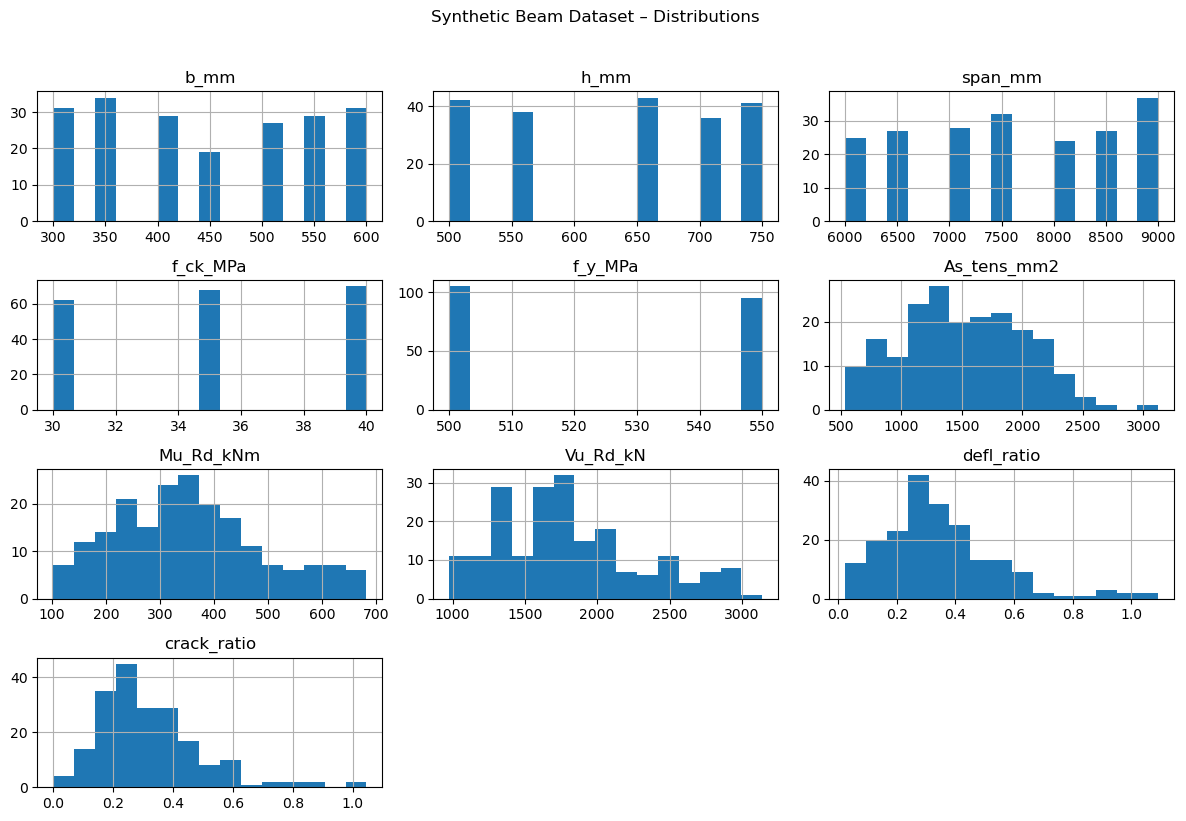

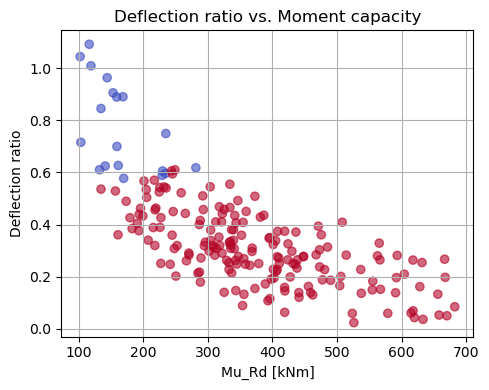

In [3]:
# Step 17 — Quick EDA of the synthetic dataset

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
DATA = ROOT / "data"
df = pd.read_csv(DATA / "beam_samples_small.csv")

print("Rows:", len(df))
print(df.describe().round(2))

# ---- Histogram overview ----
num_cols = ["b_mm","h_mm","span_mm","f_ck_MPa","f_y_MPa",
            "As_tens_mm2","Mu_Rd_kNm","Vu_Rd_kN",
            "defl_ratio","crack_ratio"]

df[num_cols].hist(figsize=(12,8), bins=15)
plt.suptitle("Synthetic Beam Dataset – Distributions", y=1.02)
plt.tight_layout()
plt.show()

# ---- Utilization scatter (demand vs. capacity) ----
plt.figure(figsize=(5,4))
plt.scatter(df["Mu_Rd_kNm"], df["defl_ratio"], c=df["is_valid"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Mu_Rd [kNm]")
plt.ylabel("Deflection ratio")
plt.title("Deflection ratio vs. Moment capacity")
plt.grid(True)
plt.tight_layout()
plt.show()
